In [2]:
'''
We are not reusing the derivatives tree so it takes a very long time to compute the jac. If we keep the derivatives tree naively, we run out of memory.
'''

#@title Autoload all modules
%load_ext autoreload
%autoreload 2
    
import sys
sys.path.insert(0, '/scratch/sa7270/p2')
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import io
import csv
import numpy as np
import pandas as pd
import matplotlib
import importlib
import os
import functools
import itertools
import torch
from losses import get_optimizer
from models.ema import ExponentialMovingAverage

import torch.nn as nn
import numpy as np
import tqdm
import io
import likelihood
import controllable_generation
from utils import restore_checkpoint
#sns.set(font_scale=2)
#sns.set(style="whitegrid")
import models
from models import utils as mutils

from models import ncsnpp
#from models import ncsnv2
#from models import ncsnpp
#from models import ddpm as ddpm_model
#from models import layerspp
#from models import layers
from models import normalization
import sampling

from likelihood import get_likelihood_fn
from sde_lib import VESDE, VPSDE, subVPSDE
from sampling import (ReverseDiffusionPredictor, 
                      LangevinCorrector, 
                      EulerMaruyamaPredictor, 
                      AncestralSamplingPredictor, 
                      NoneCorrector, 
                      NonePredictor,
                      AnnealedLangevinDynamics)
import datasets2 as datasets

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/scratch/sa7270/p2/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Using /home/sa7270/.cache/torch_extensions/py312_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/sa7270/.cache/torch_extensions/py312_cu121/upfirdn2d/build.ninja...
/scratch/sa7270/p2/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module upfirdn2d...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF upfirdn2d.o.d -DTORCH_EXTENSION_NAME=upfirdn2d -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /scratch/sa7270/p2/torch/include -isystem /scratch/sa7270/p2/torch/include/torch/csrc/api/include -isystem /scratch/sa7270/p2/torch/include/TH -isystem /scratch/sa7270/p2/torch/include/THC -isystem /usr/local/cuda/include -isystem /ext3/miniconda3/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /scratch/sa7270/env2/score8/op/upfirdn2d.cpp -o upfirdn2d.o 
In file included from /scratch/sa7270/p2/torch/include/c10/util/Exception.h:5,
                 from /scratch/sa7270/p2/torch/include/c10/core/Device.h:5,
                 from /scratch/sa7270/p2/torch/include/ATen/core/TensorBody.h:11,
                 from /scratch/sa7270/p2/torch/include/ATen/core/Tensor.h:3,
                 from /scratch/sa7270/p2/torch/include/ATen/Tensor.h:3,
                 from /scrat

Loading extension module upfirdn2d...


In [3]:
# @title Load the score-based model
from configs.vp import cifar10_ddpmpp_continuous as configs  
ckpt_filename = "../cifar2/exp/checkpoint_26.pth"
config = configs.get_config()
sde = VPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
sampling_eps = 1e-3

batch_size =   1#@param {"type":"integer"}
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

random_seed = 0 #@param {"type": "integer"}

sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
score_model = mutils.create_model(config)

optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)

state = restore_checkpoint(ckpt_filename, state, config.device)
ema.copy_to(score_model.parameters())

/scratch/sa7270/env2/score8/utils.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_state = torch.load(ckpt_dir, map_location=device)


In [4]:
#@title Visualization code

def image_grid(x):
  size = config.data.image_size
  channels = config.data.num_channels
  img = x.reshape(-1, size, size, channels)
  w = int(np.sqrt(img.shape[0]))
  img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
  return img

def show_samples(x):
  x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
  img = image_grid(x)
  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(img)
  plt.show()


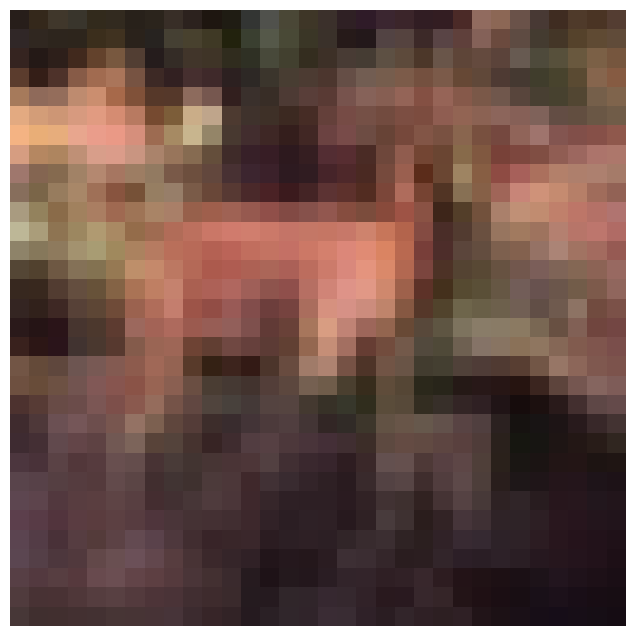

In [203]:
#@title PC sampling
img_size = config.data.image_size
channels = config.data.num_channels
shape = (batch_size, channels, img_size, img_size)
predictor = EulerMaruyamaPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = None #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16 #@param {"type": "number"}
n_steps =  1#@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}
sampling_fn = sampling.get_pc_sampler(sde, shape, predictor, corrector,
                                      inverse_scaler, snr, n_steps=n_steps,
                                      probability_flow=probability_flow,
                                      continuous=config.training.continuous,
                                      eps=sampling_eps, device=config.device)

x, n = sampling_fn(score_model)
show_samples(x)

In [242]:
from PIL import Image
from torchvision import transforms

img = Image.open('img4.png')
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()         
])
x1 = transform(img).to(device)
x1 = x1.unsqueeze(0)

In [246]:
x1 = x

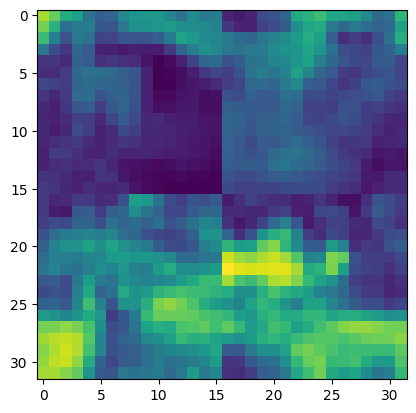

In [249]:
plt.imshow(torch.abs(torch.fft.fftshift(x1[0, 0]).detach().cpu()))

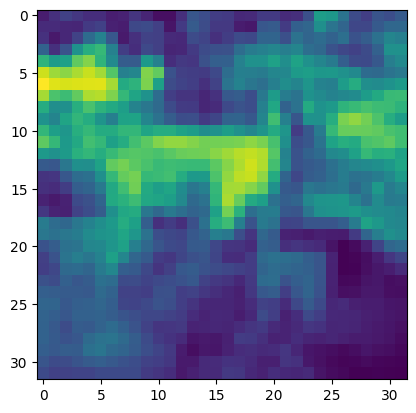

In [250]:
plt.imshow(x1.detach().cpu()[0,0])

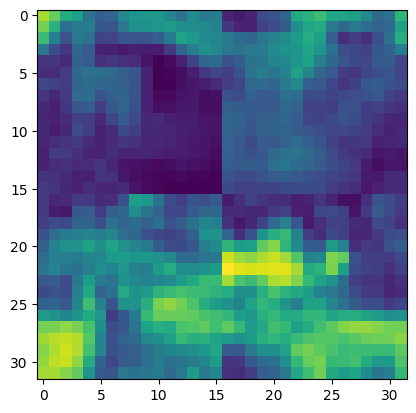

In [251]:
plt.imshow(torch.abs(torch.fft.fftshift(x1[0, 0]).detach().cpu()))

In [287]:
from models.utils import idea
import pysteps

x0 = torch.randn_like(x1)
device = torch.device('cuda:0')
a = np.array([idea(x0, x1, torch.tensor([t], device=device), score_model).cpu().detach().numpy() for t in torch.linspace(.99, 0, 100)])

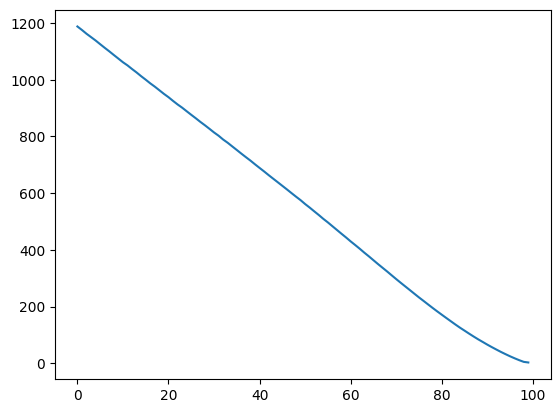

In [288]:
plt.plot(a)

In [281]:
b = np.array([pysteps.utils.spectral.rapsd(np.abs(aa)) for aa in a])

0


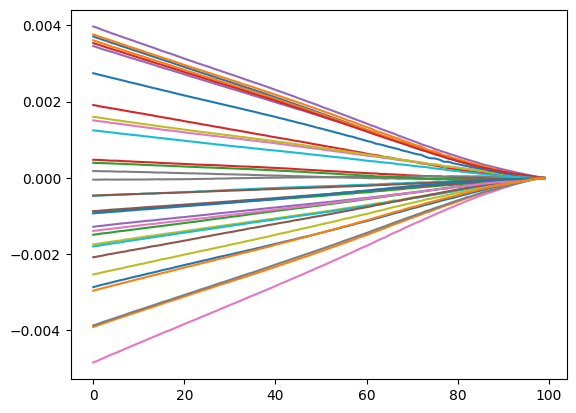

1


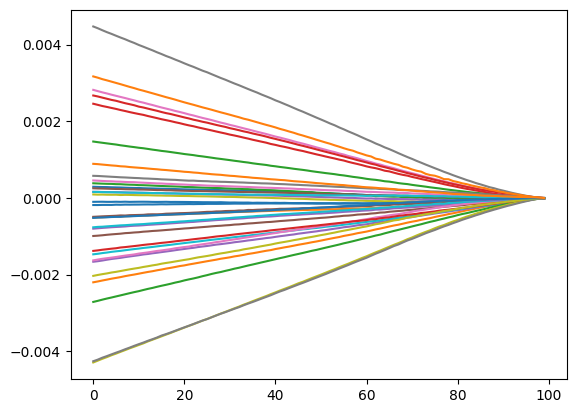

2


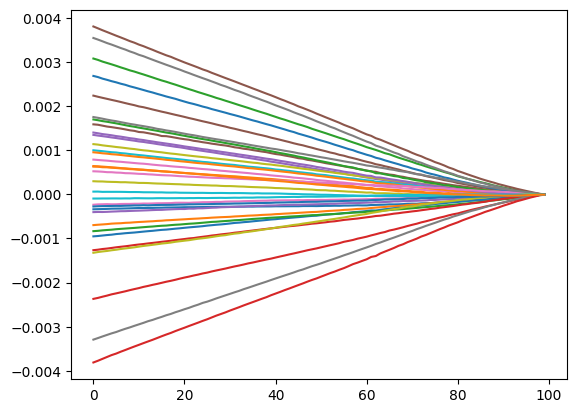

3


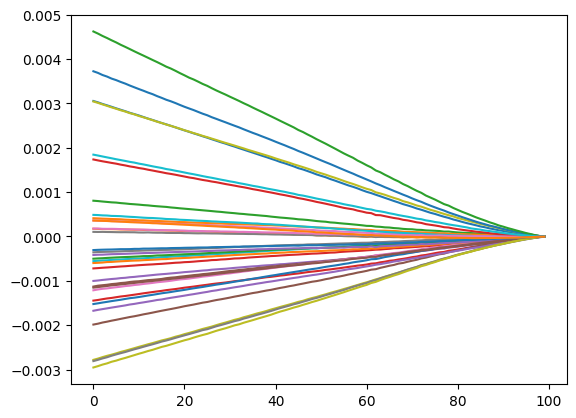

4


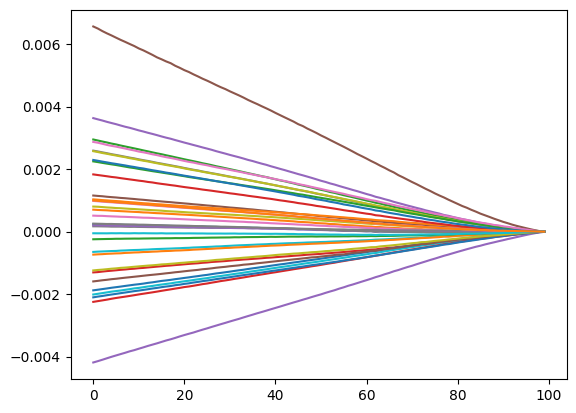

5


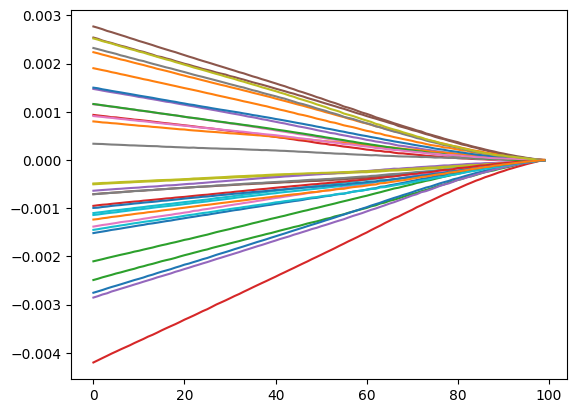

6


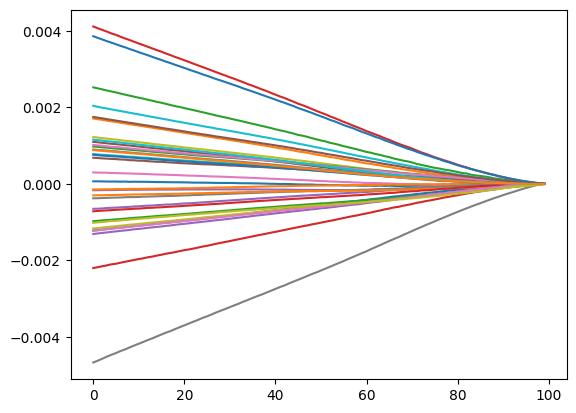

7


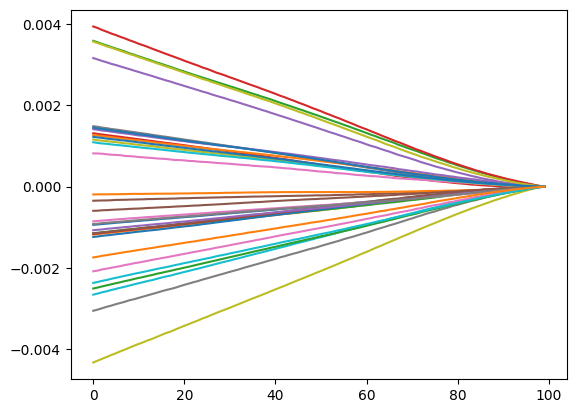

8


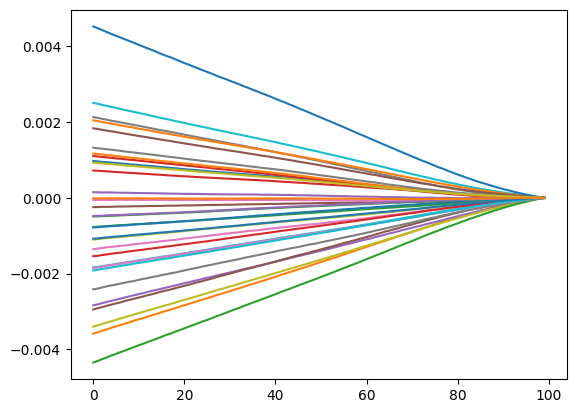

9


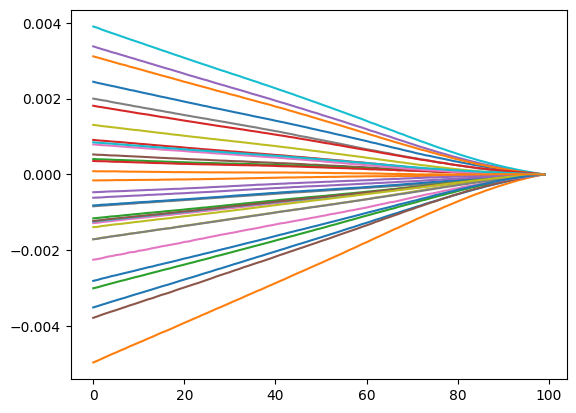

10


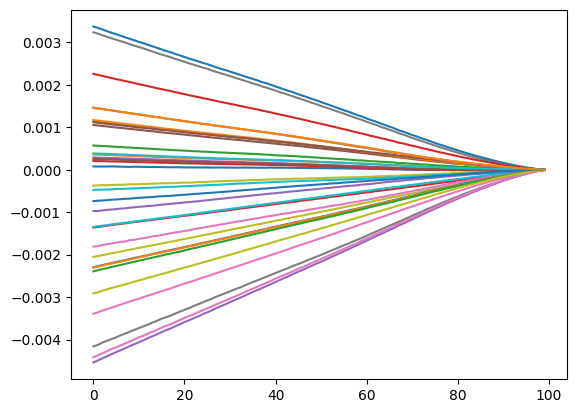

11


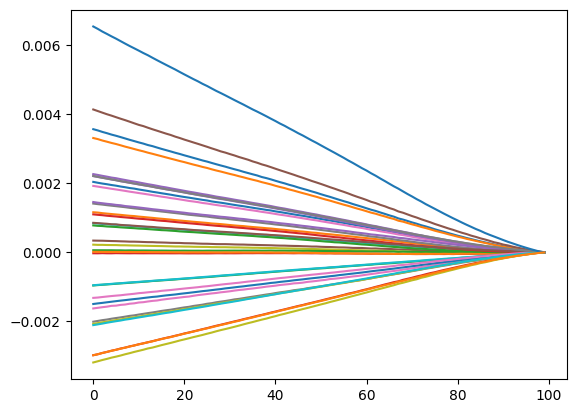

12


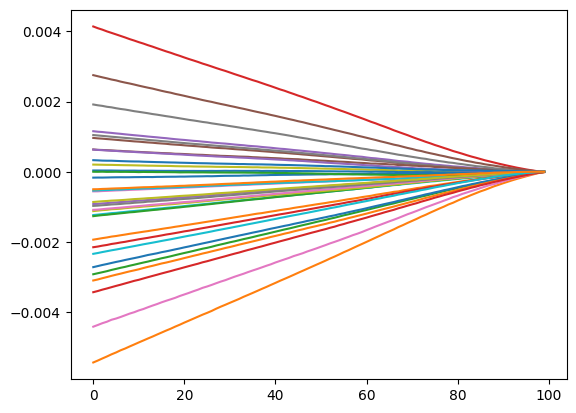

13


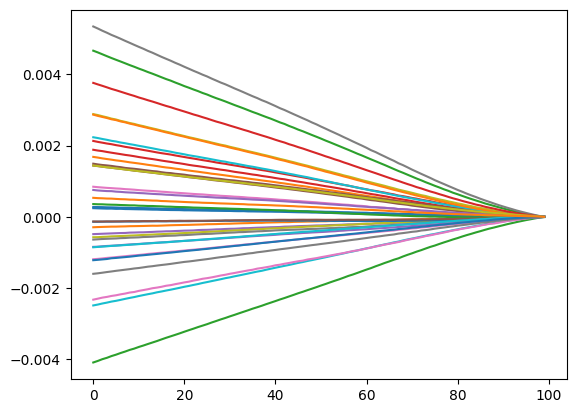

14


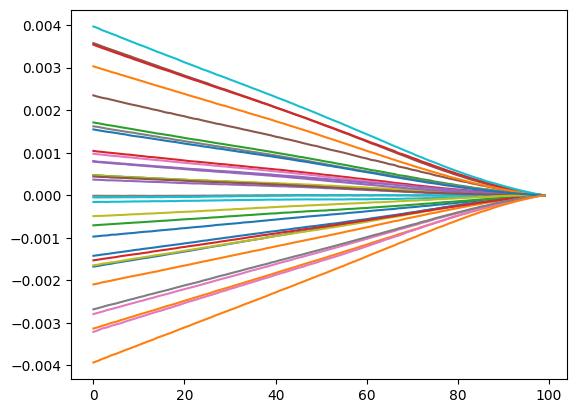

15


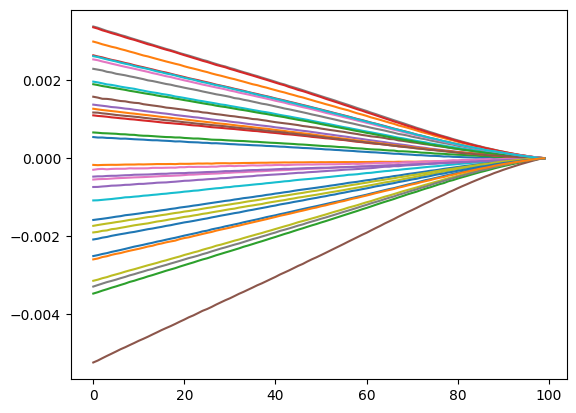

16


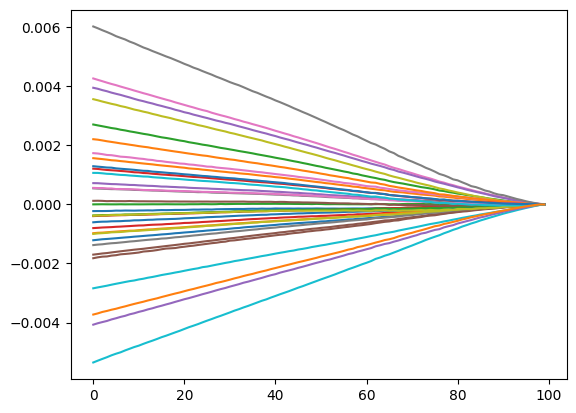

17


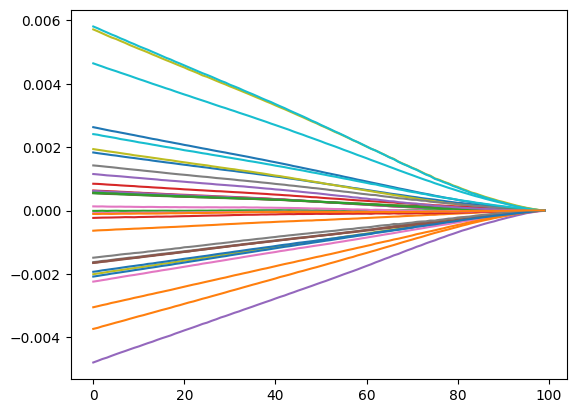

18


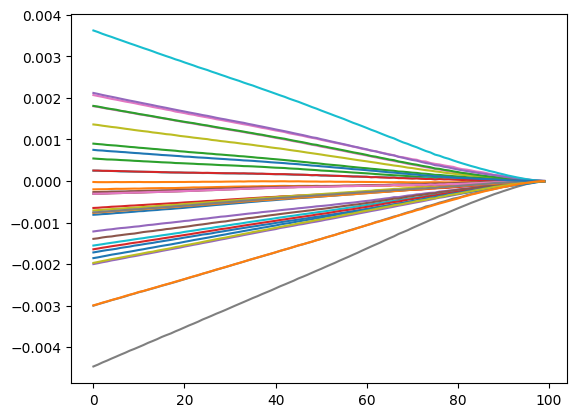

19


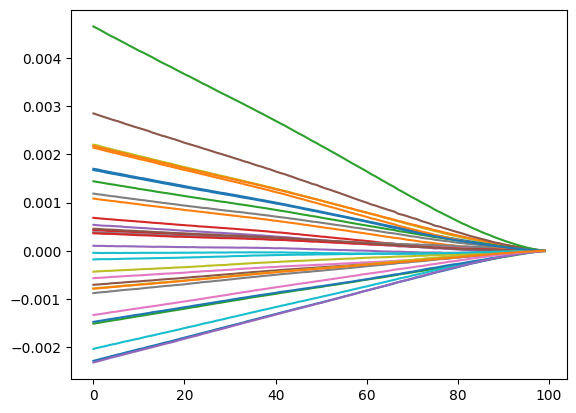

20


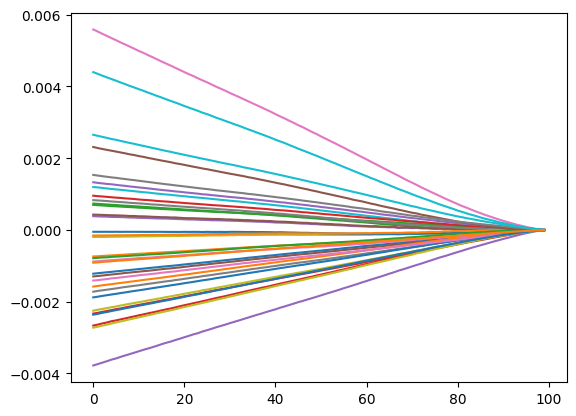

21


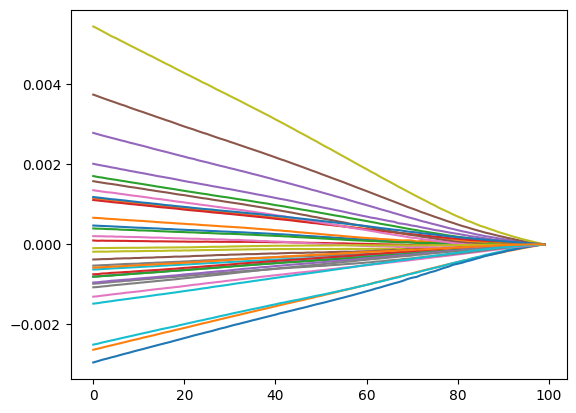

22


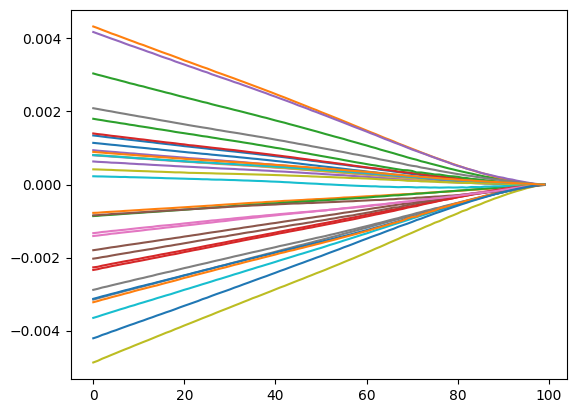

23


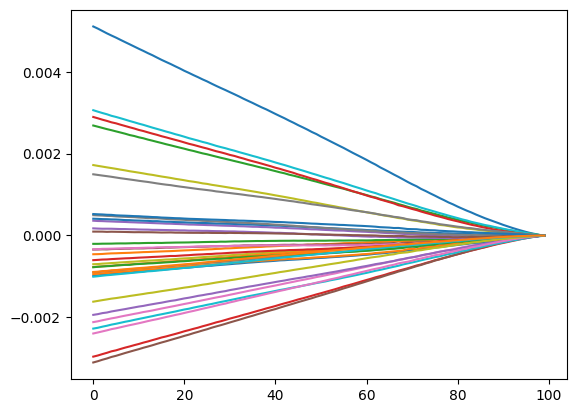

24


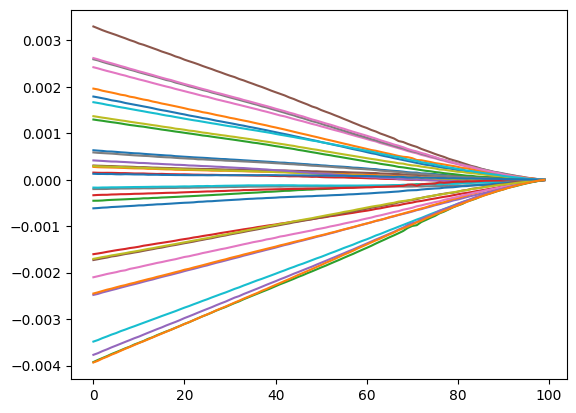

25


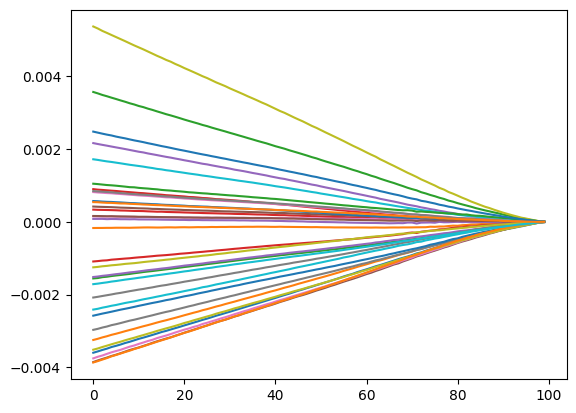

26


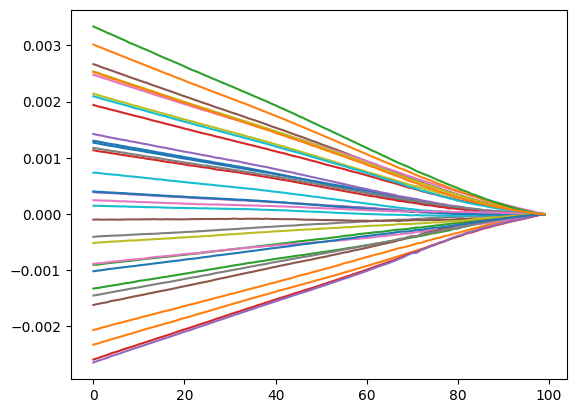

27


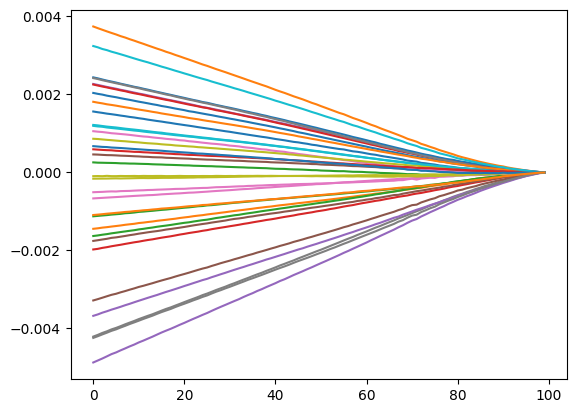

28


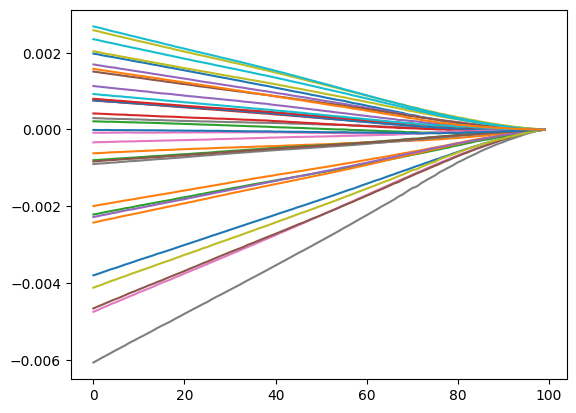

29


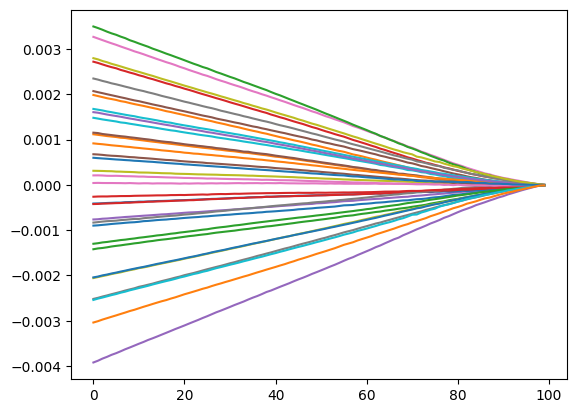

30


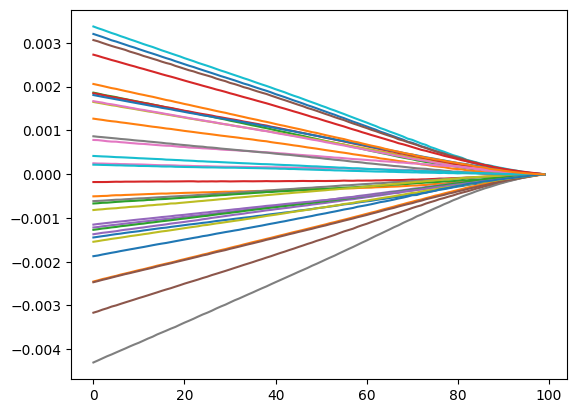

31


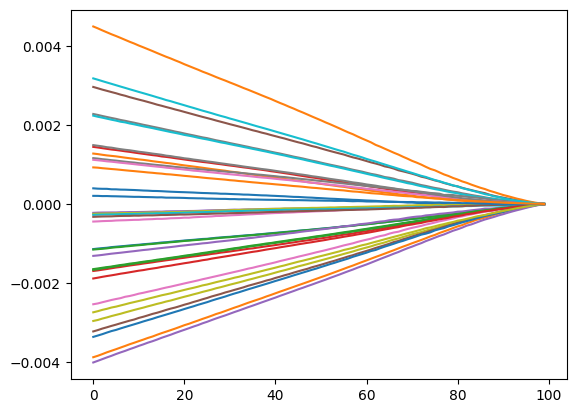

In [282]:
for i in range(32):
    print(i)
    plt.plot(a[:, i, :]);
    plt.show()

0


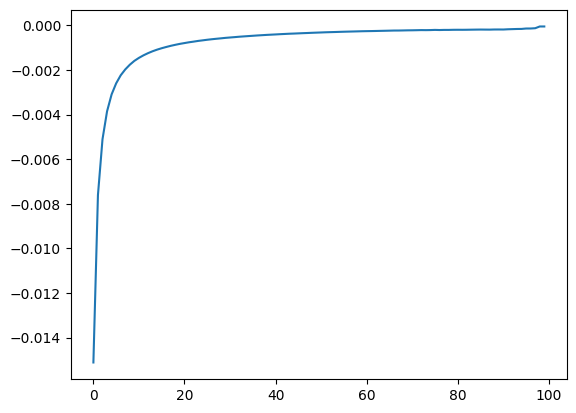

1


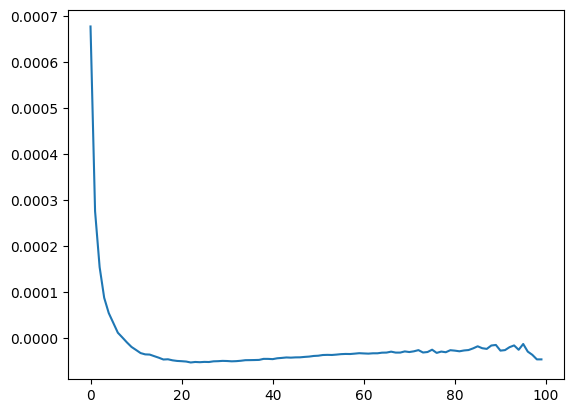

2


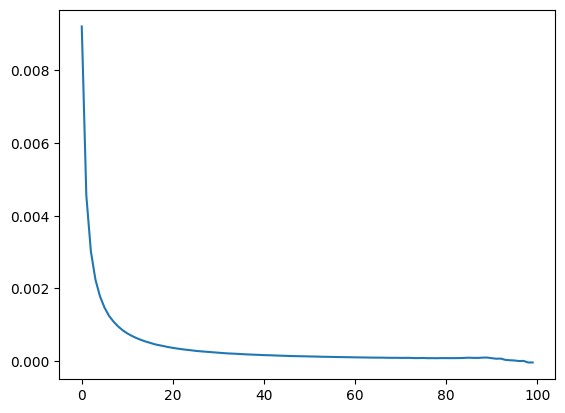

3


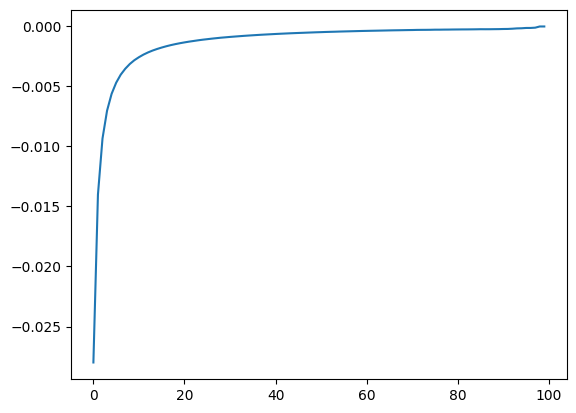

4


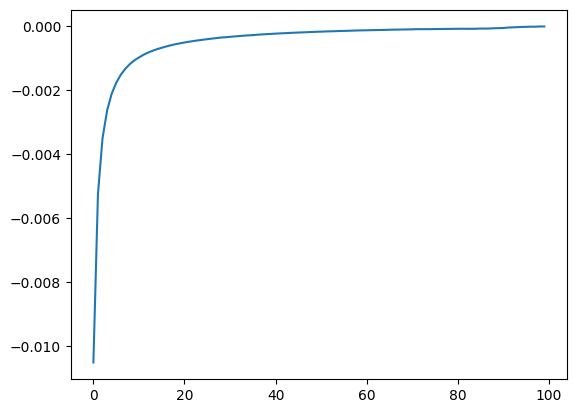

5


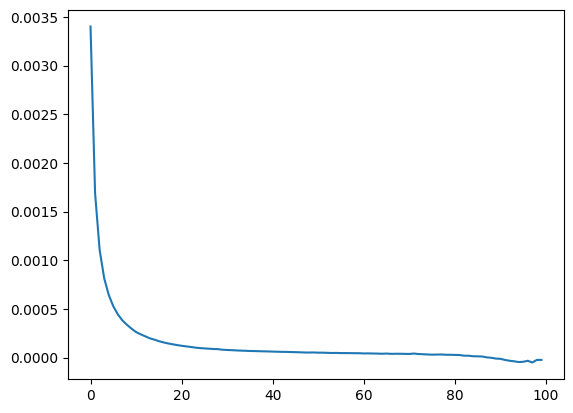

6


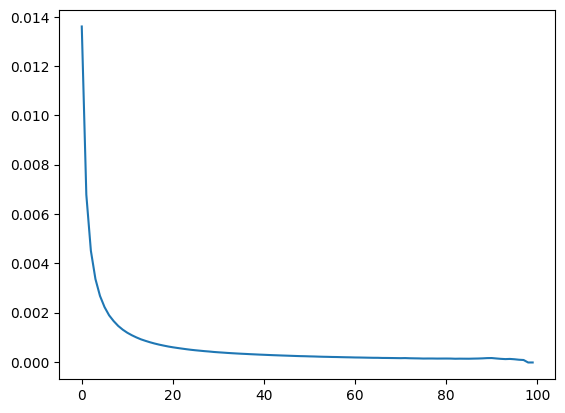

7


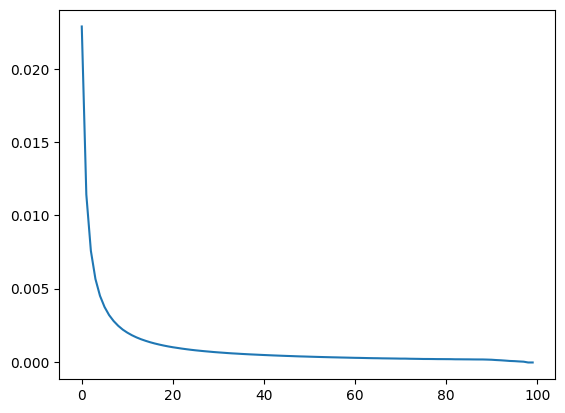

8


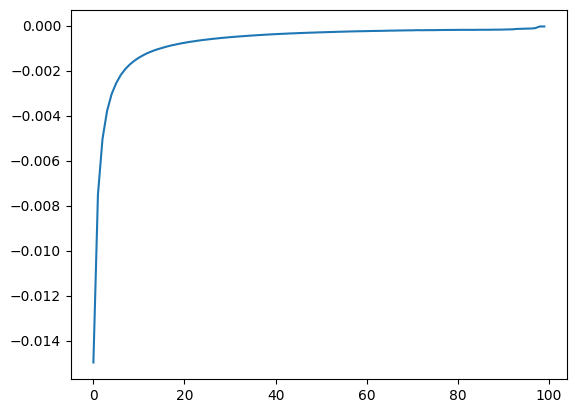

9


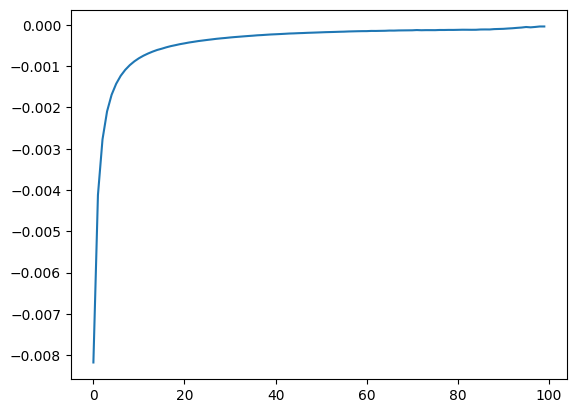

10


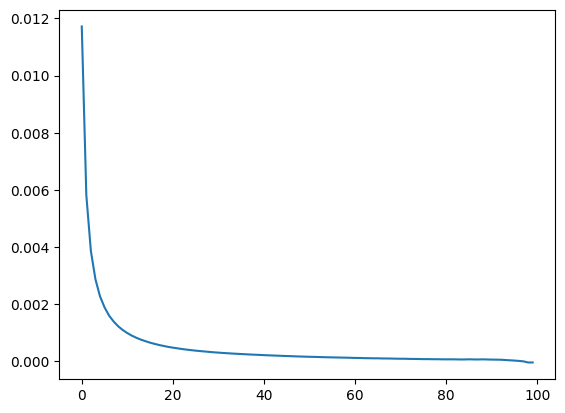

11


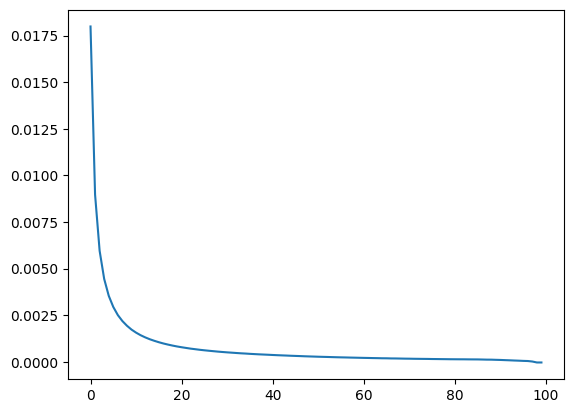

12


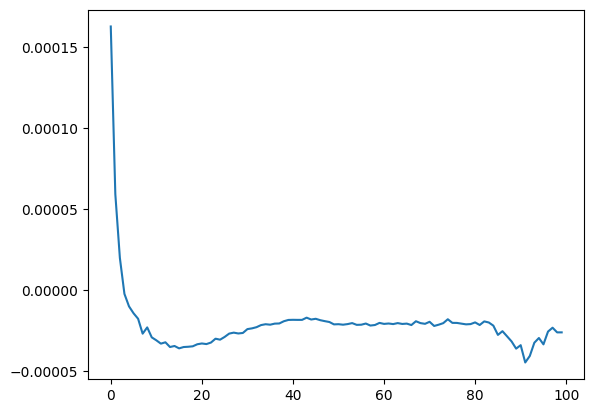

13


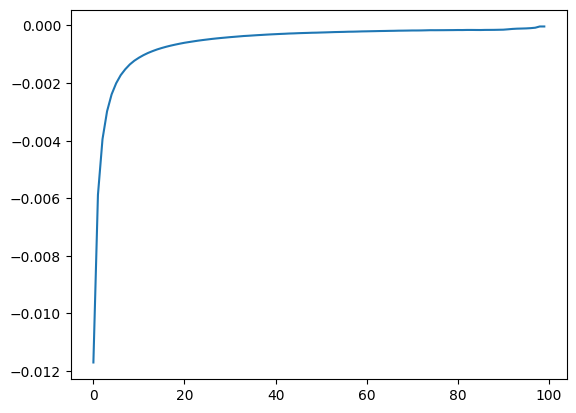

14


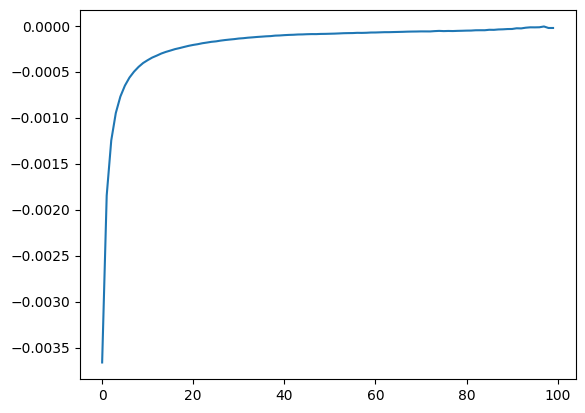

15


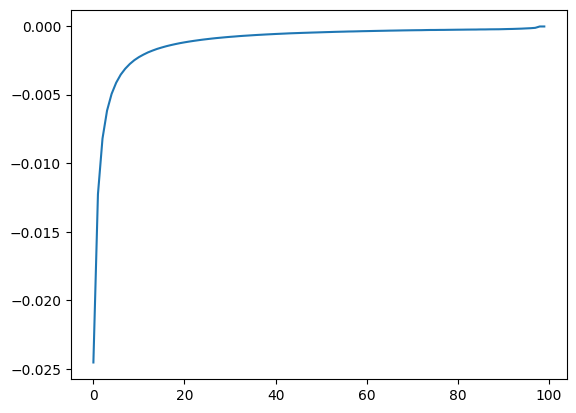

16


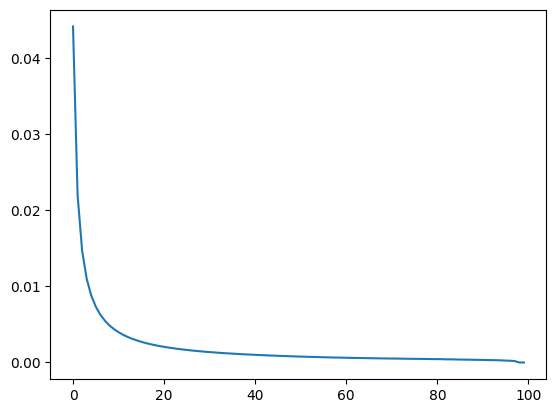

17


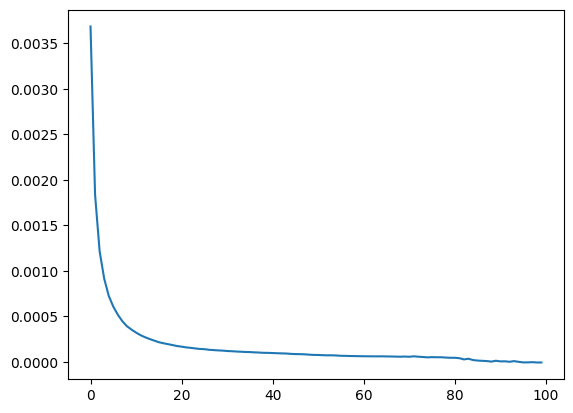

18


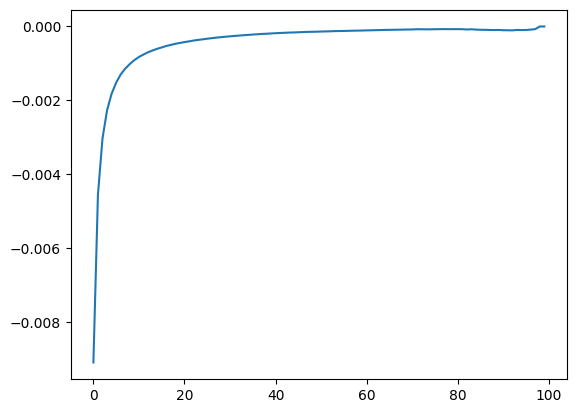

19


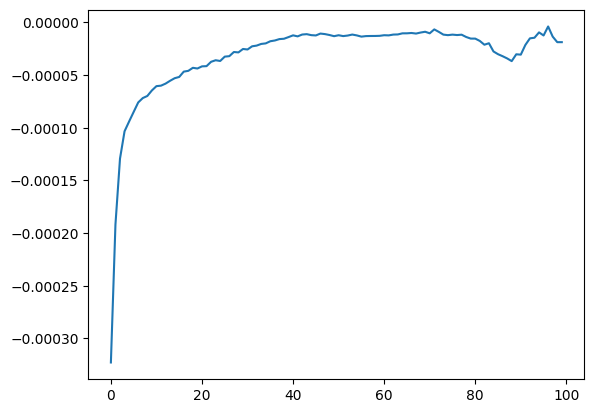

20


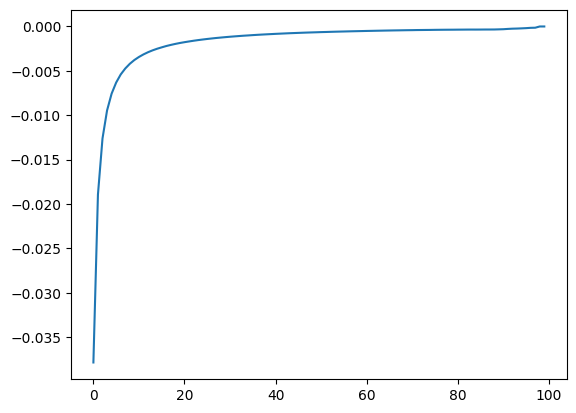

21


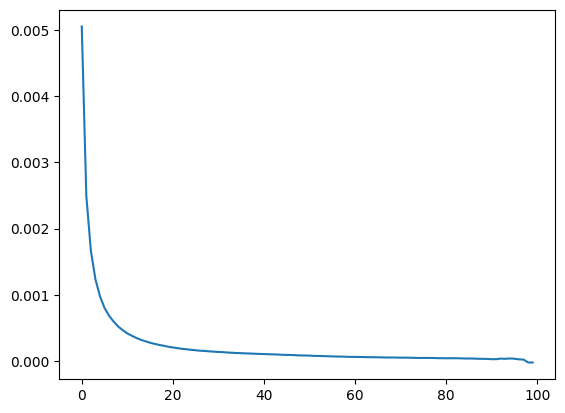

22


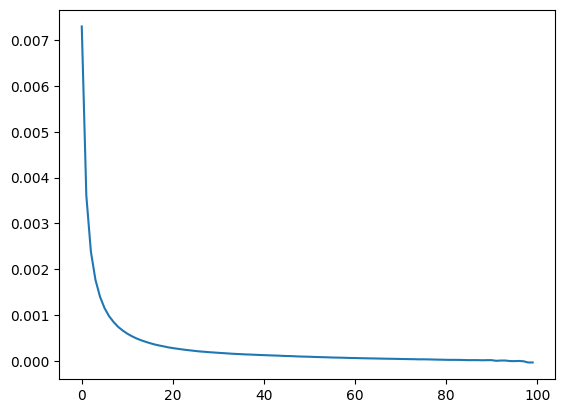

23


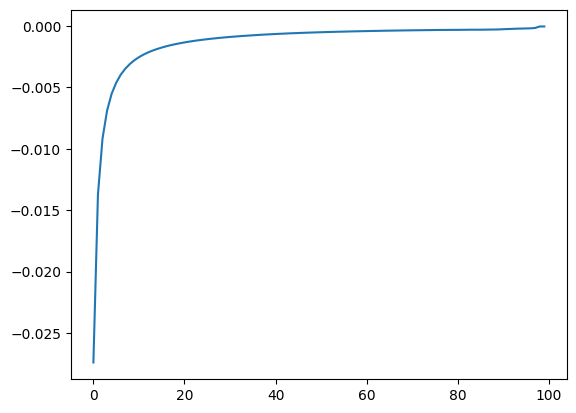

24


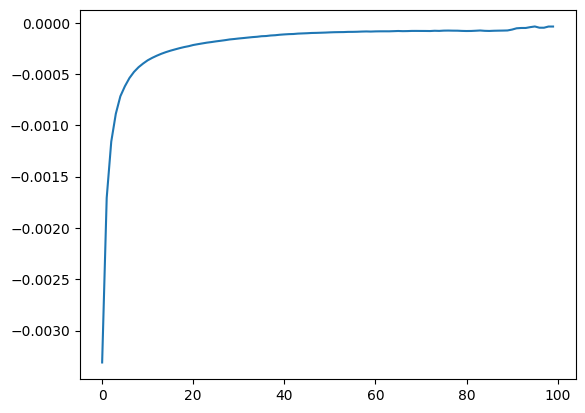

25


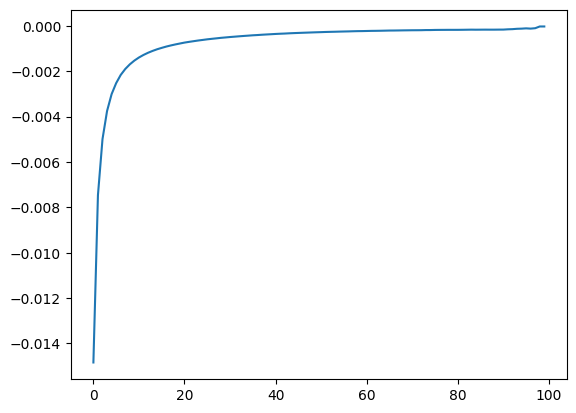

26


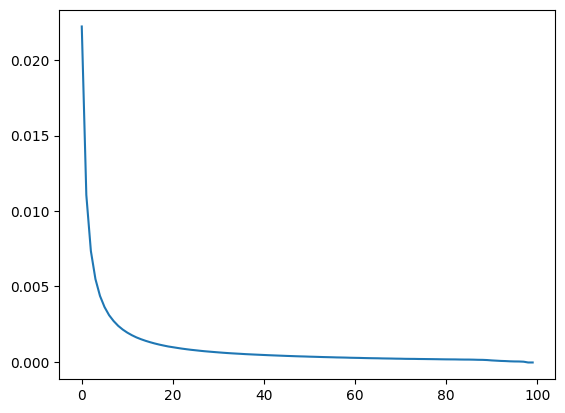

27


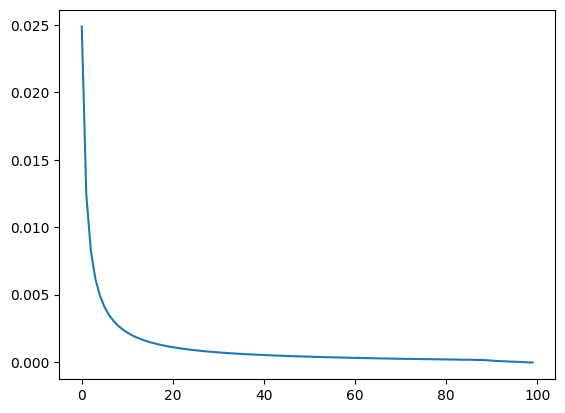

28


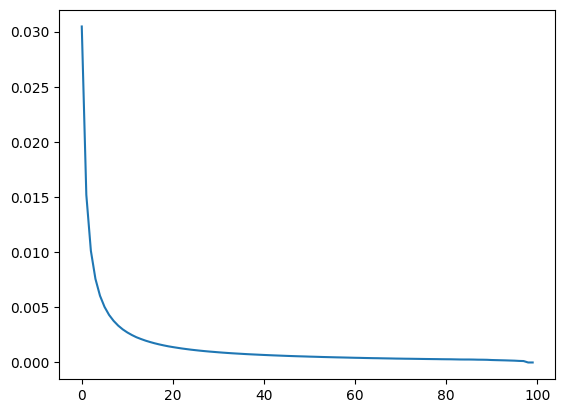

29


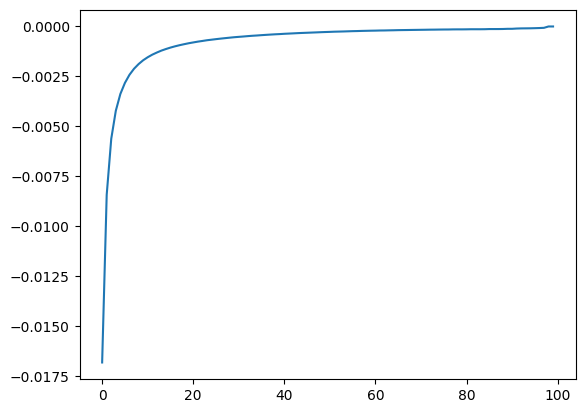

30


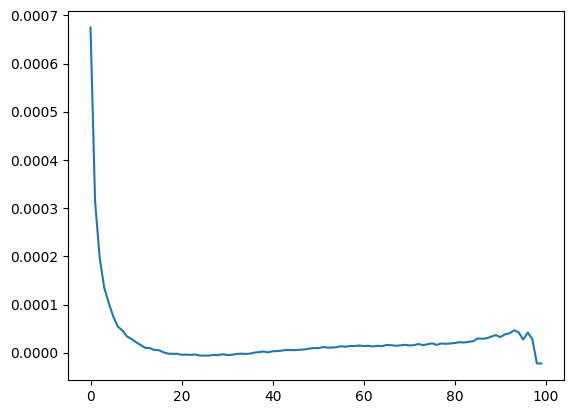

31


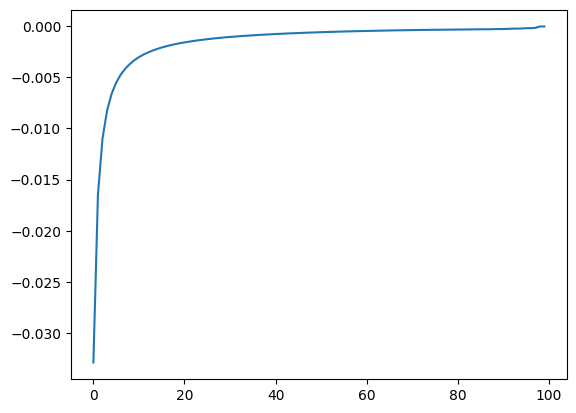

In [278]:
for i in range(32): 
    print(i)
    plt.plot(a[:, 0, i]);
    plt.show()

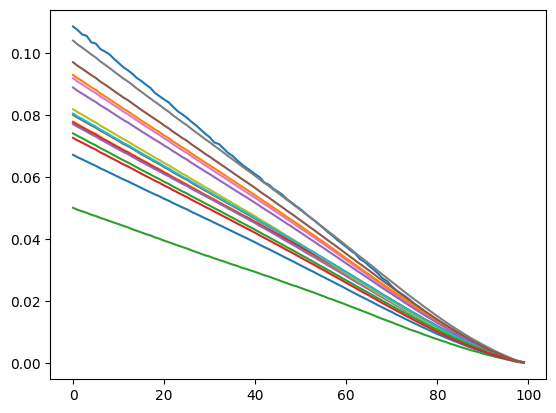

In [254]:
plt.plot(b);

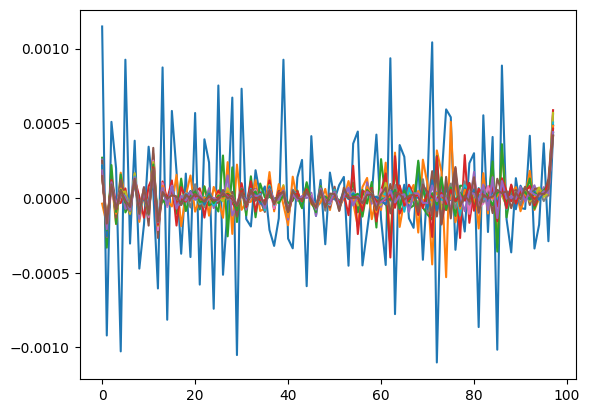

In [176]:
plt.plot(np.diff(np.diff(b, axis=0), axis=0));

In [129]:
np.abs(a[:, 10, 10])

array([0.39872622, 0.39429596, 0.38980624, 0.38566014, 0.38167933,
       0.37710598, 0.37313288, 0.36865506, 0.3650033 , 0.360111  ,
       0.35645315, 0.3523737 , 0.34857792, 0.34339517, 0.33962184,
       0.33576936, 0.33166075, 0.32704064, 0.32297182, 0.31858346,
       0.31459194, 0.31039384, 0.3067379 , 0.30249178, 0.2982765 ,
       0.29390866, 0.29030892, 0.28580508, 0.2814519 , 0.2772148 ,
       0.27340743, 0.26904088, 0.2650643 , 0.26082647, 0.25669786,
       0.25209793, 0.24852552, 0.24390596, 0.2402699 , 0.235532  ,
       0.2314893 , 0.22720651, 0.22312483, 0.21878922, 0.21475014,
       0.21035647, 0.20597087, 0.20166132, 0.19718492, 0.19300553,
       0.18864973, 0.18398483, 0.17955607, 0.17472245, 0.17077735,
       0.16637675, 0.16153811, 0.1571455 , 0.15290056, 0.14819495,
       0.14377992, 0.13908966, 0.13441977, 0.13039325, 0.12545979,
       0.12114958, 0.11595016, 0.1119481 , 0.10774883, 0.10329973,
       0.09829494, 0.09400598, 0.08901888, 0.085467  , 0.08077

0


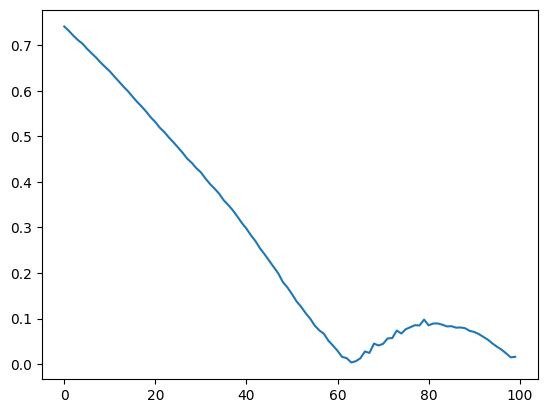

1


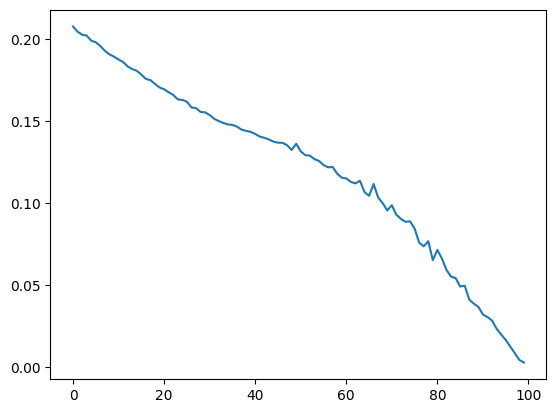

2


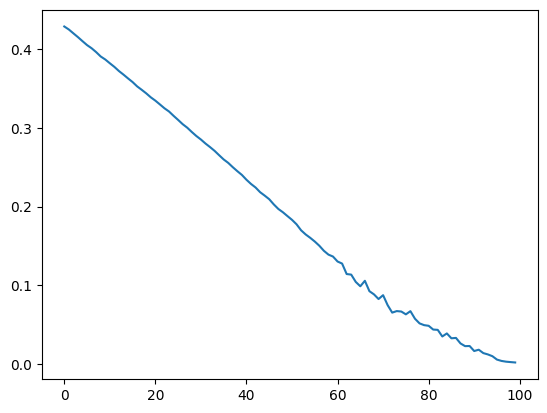

3


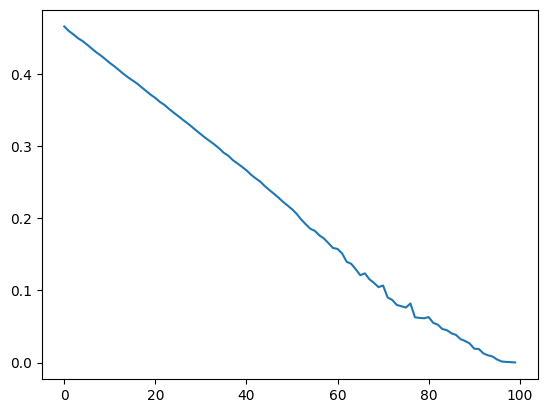

4


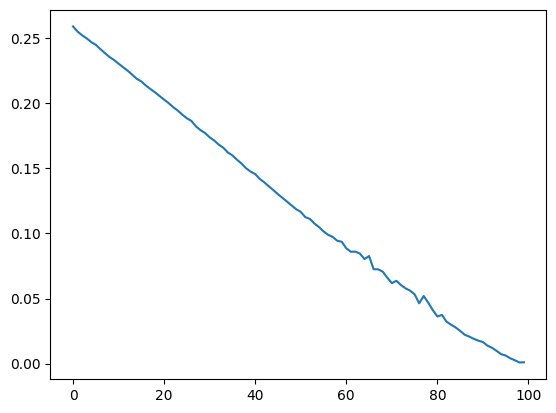

5


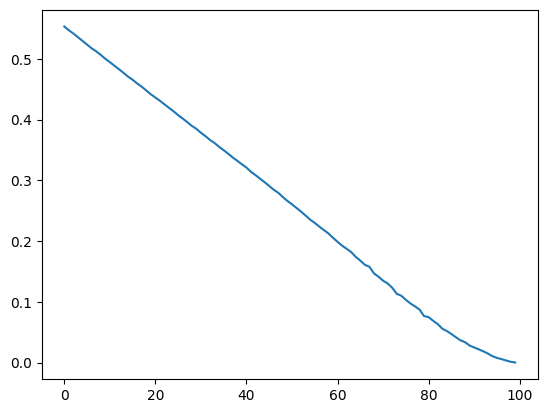

6


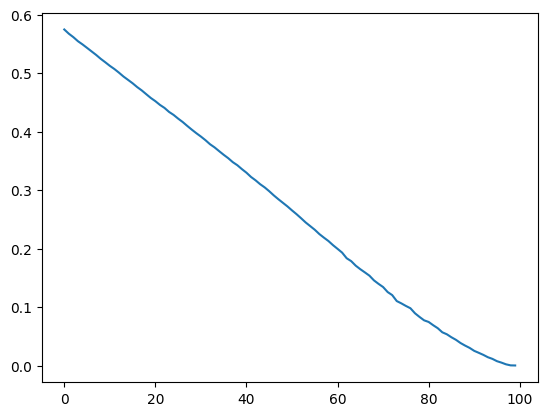

7


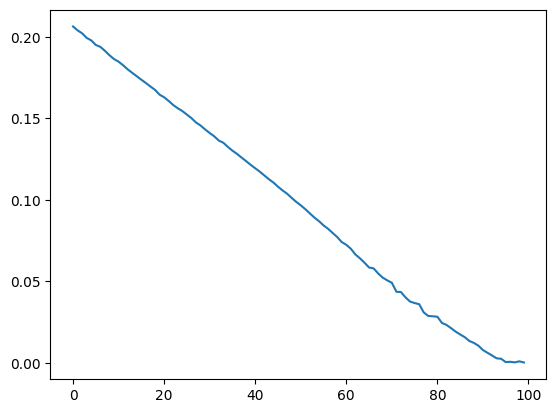

8


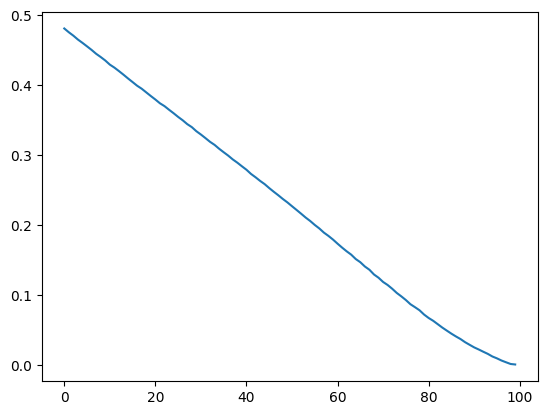

9


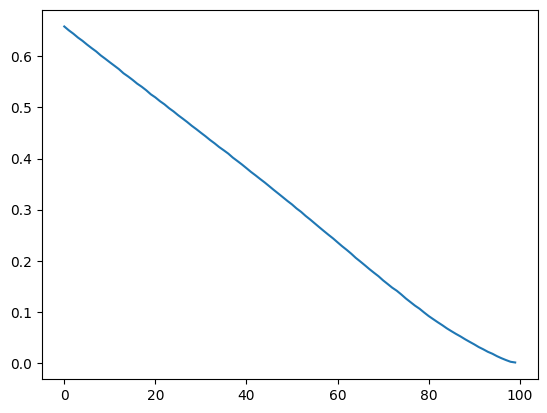

10


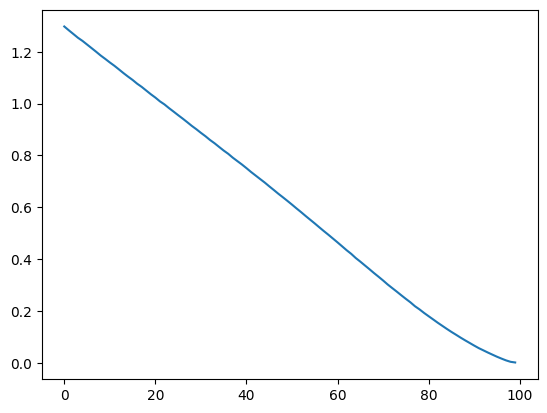

11


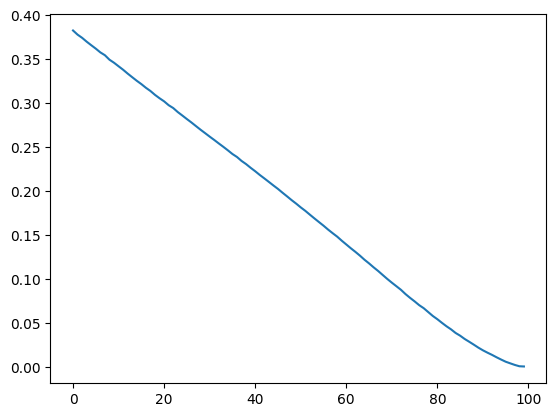

12


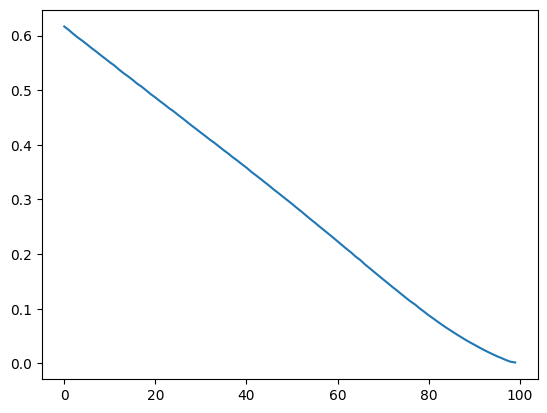

13


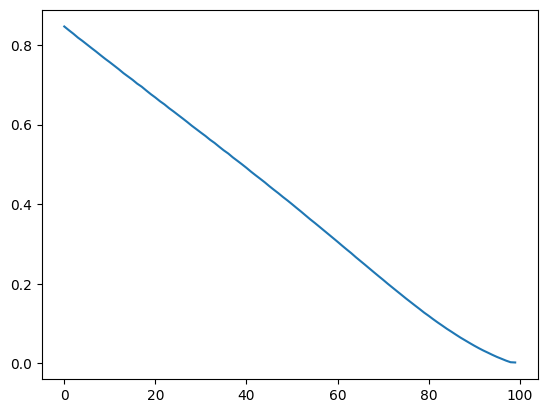

14


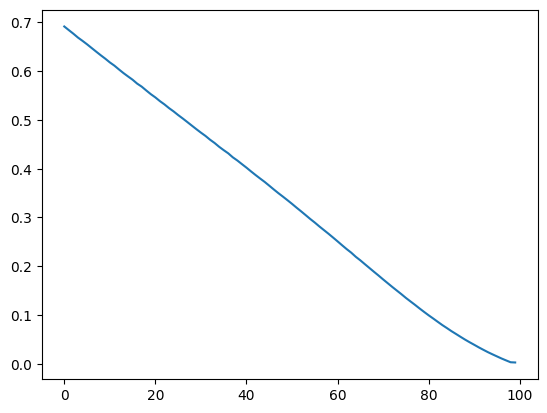

15


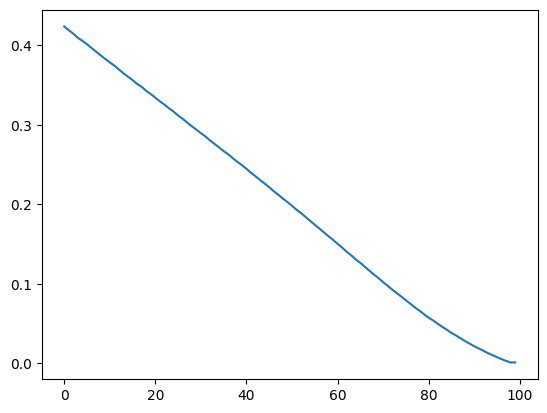

16


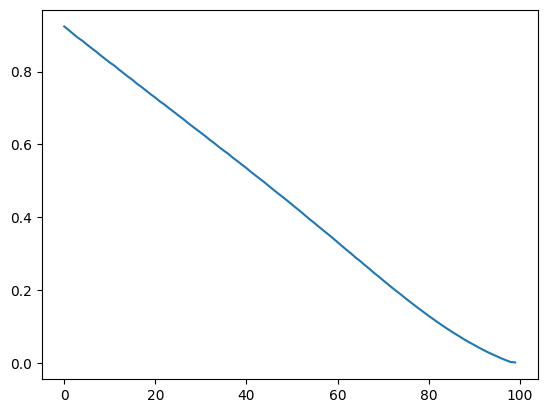

17


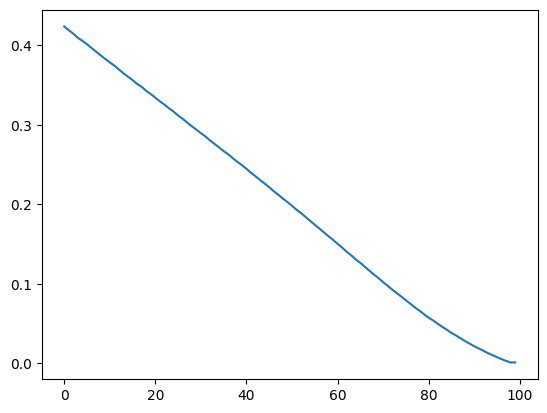

18


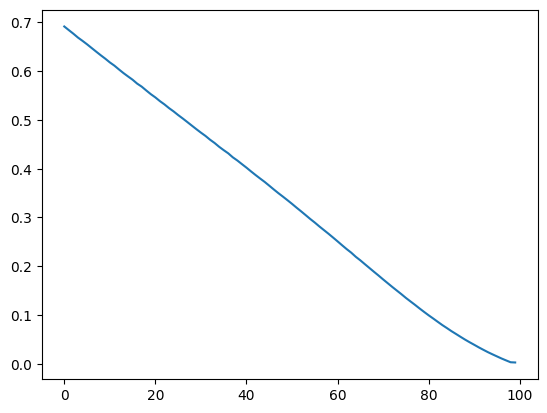

19


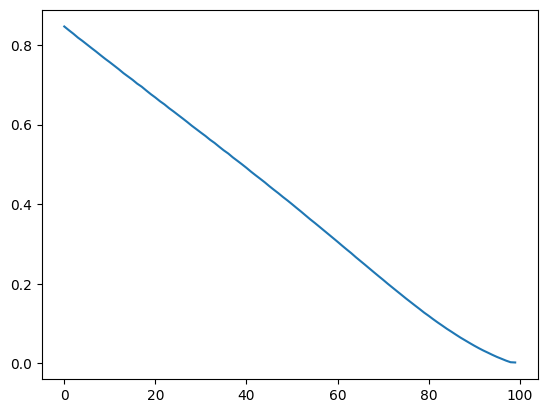

20


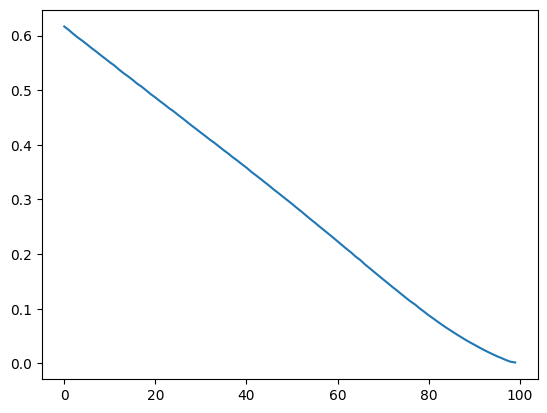

21


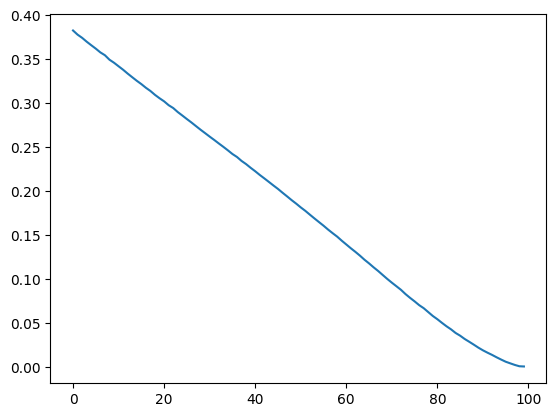

22


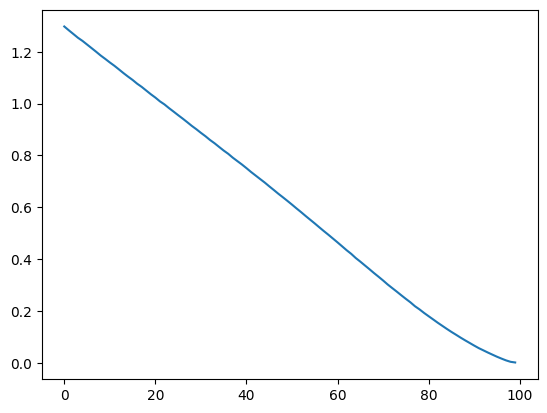

23


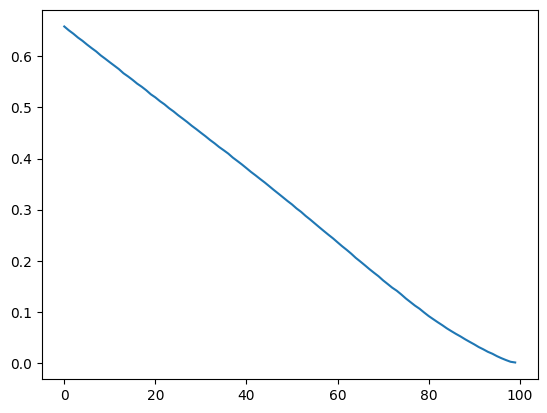

24


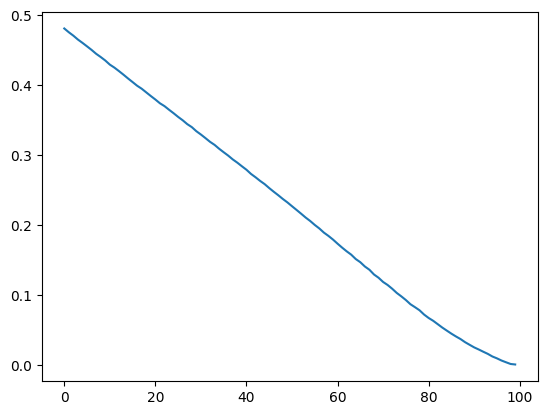

25


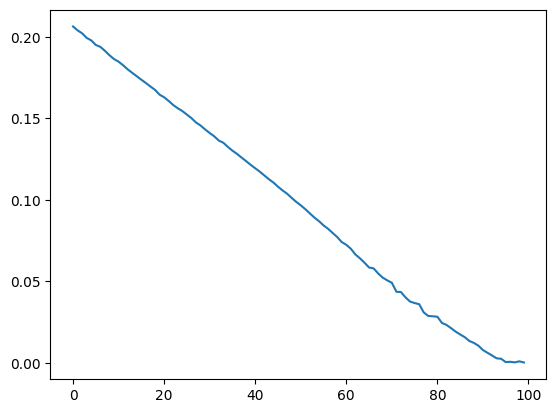

26


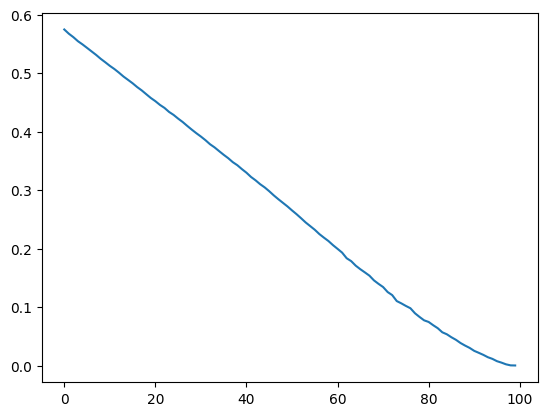

27


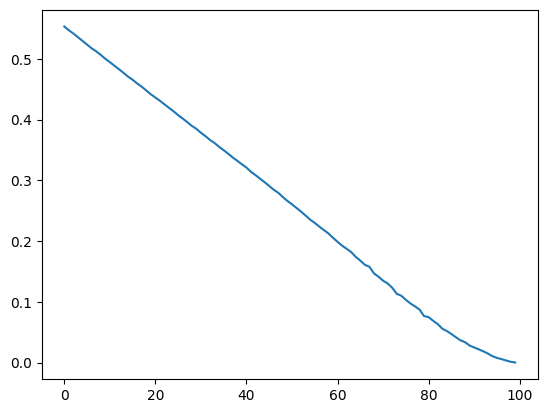

28


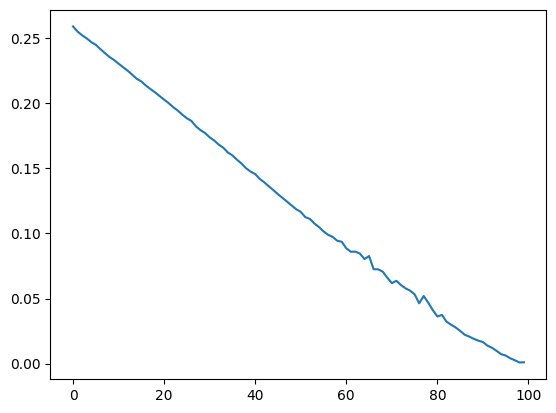

29


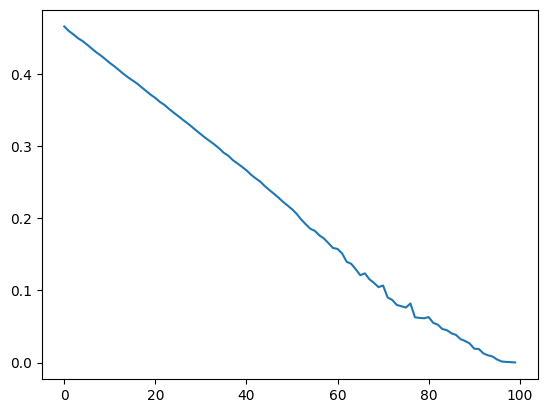

30


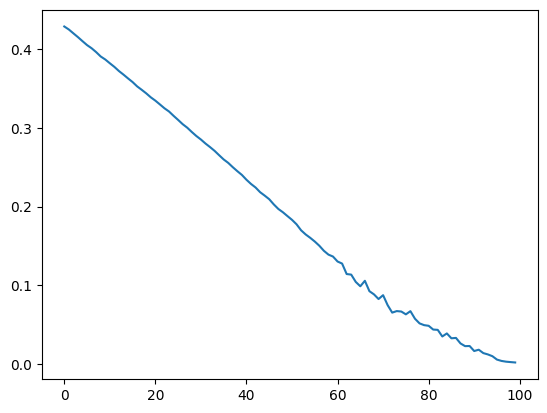

31


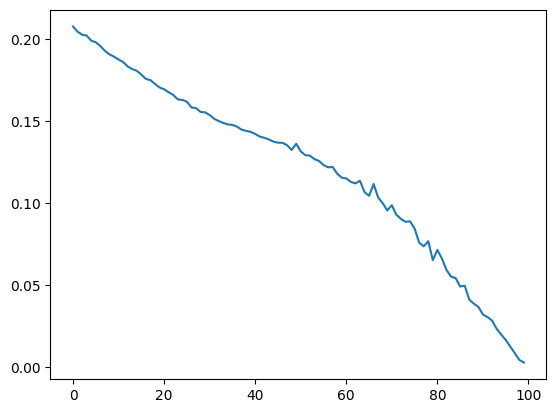

In [130]:
b = a.reshape(100, 32*32)
for i in range(32):
    print(i)
    plt.plot(np.abs(a[:, 3, i]))
    plt.show()

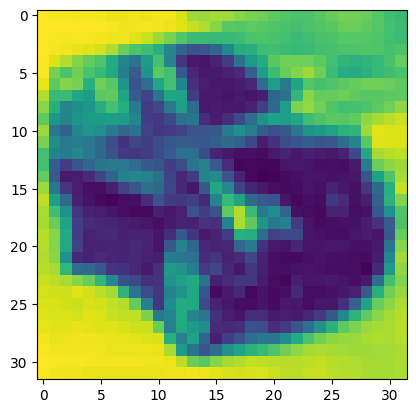

In [85]:
plt.imshow(torch.abs(x1[0, 1]).detach().cpu())

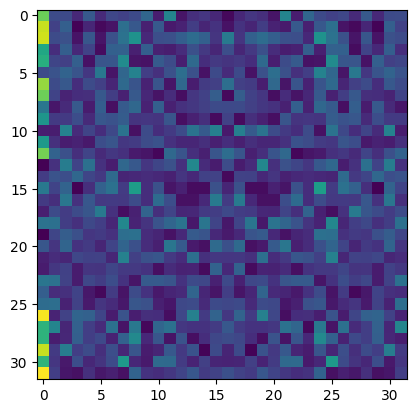

In [89]:
a = idea(x0, x1, torch.tensor([.1], device=device), score_model)
plt.imshow(torch.abs(a).detach().cpu())

/ext3/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)


ValueError: x and y can be no greater than 2D, but have shapes (100,) and (100, 1, 3, 32, 32)

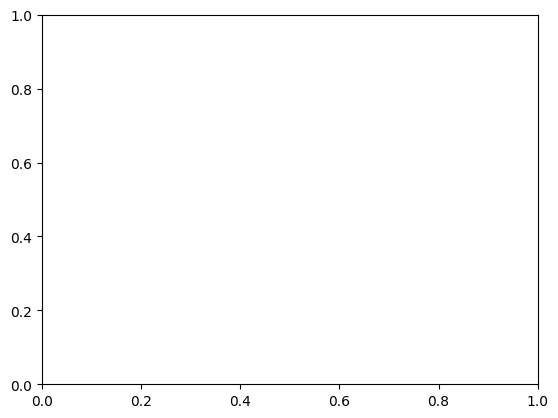

In [46]:
import matplotlib.pyplot as plt
plt.plot(a)

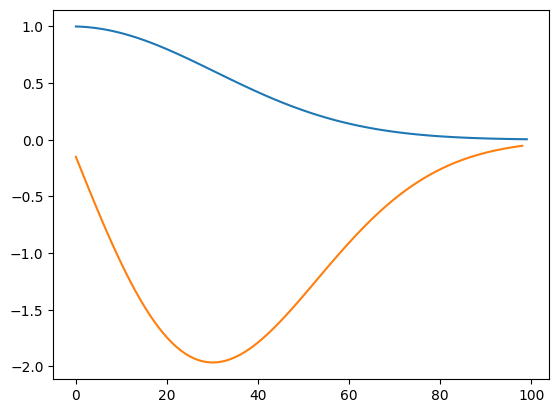

In [40]:
import matplotlib.pyplot as plt
dbetas = [(betas[i+1] - betas[i])*100 for i in range(99)]
plt.plot(betas)
plt.plot(dbetas)

In [20]:
 #@title ODE sampling
batch_size = 1
shape = (batch_size, 3, 32, 32)
sampling_fn = sampling.get_ode_sampler(sde,                                        
                                       shape, 
                                       inverse_scaler,                                       
                                       denoise=True, 
                                       eps=sampling_eps,
                                       device=config.device)
x, nfe, accs, ps = sampling_fn(score_model)
#show_samples(x)

0.9999898049031521 0.004515538700491977
0.9999872561126993 0.005048525744665563
0.9999841100413432 0.0056373455475726905
0.9999802368281422 0.0062869669263190256
0.9999754807991943 0.007002699509488822
0.9999696558834245 0.007790206183767577
0.9999625403300831 0.008655514808878455
0.9999538706446012 0.009605029041086979
0.99994333465384 0.010645538096244045
0.9999305636066314 0.011784225274685388
0.999915123211024 0.013028675062439755
0.9998965035060781 0.014386878616277878
0.999874107463636 0.01586723743432419
0.9998472382145243 0.01747856500941958
0.9998150847944127 0.01923008625933448
0.9997767063073906 0.02113143452645356
0.9997310144105307 0.023192645939849724
0.9996767540306415 0.02542415093489337
0.999612482235352 0.02783676272985249
0.999536545194947 0.030441662565468618
0.9994470531892207 0.03325038152236803
0.9993418536352728 0.03627477874249583
0.9992185021377784 0.03952701589463282
0.9990742315929186 0.04301952774053992
0.9989059194108327 0.0467649886774165
0.99871005295904

In [54]:
a = np.array([p[15].detach().cpu().numpy() for p in ps])
#plt.plot()

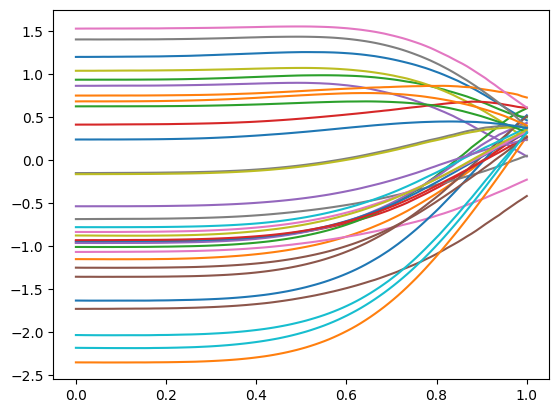

In [57]:
for i in range(32):
    plt.plot(np.linspace(0,1,99), a[:, i]);

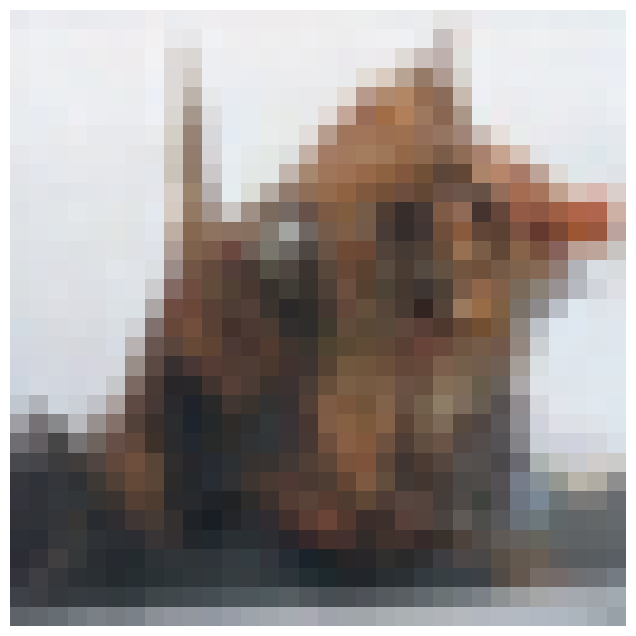

In [7]:
show_samples(x)

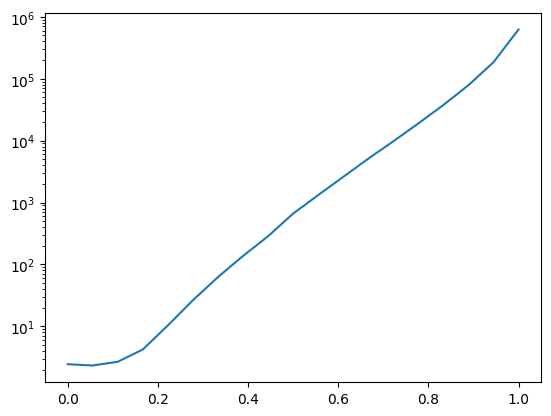

In [9]:
plt.semilogy(np.linspace(0,1,19), [acc.cpu() for acc in accs])

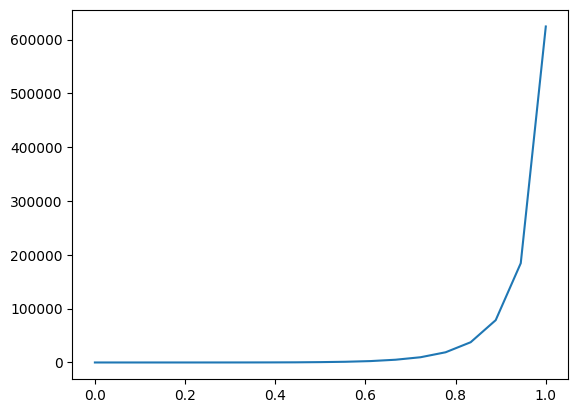

In [8]:
plt.plot(np.linspace(0,1,19), [acc.cpu() for acc in accs])

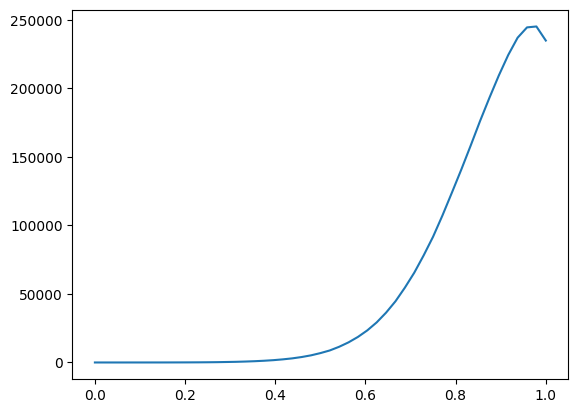

In [7]:
plt.plot(np.linspace(0,1,49), [acc.cpu() for acc in accs])

tensor(2.3956, device='cuda:0')
tensor(2.2421, device='cuda:0')
tensor(2.1900, device='cuda:0')
tensor(3.4822, device='cuda:0')
tensor(8.8339, device='cuda:0')
tensor(22.7247, device='cuda:0')
tensor(49.8657, device='cuda:0')
tensor(101.1732, device='cuda:0')
tensor(211.0269, device='cuda:0')
tensor(464.6755, device='cuda:0')
tensor(1120.0602, device='cuda:0')
tensor(2627.3135, device='cuda:0')
tensor(5526.1011, device='cuda:0')
tensor(9984.4424, device='cuda:0')
tensor(18632.7520, device='cuda:0')
tensor(36652.4258, device='cuda:0')
tensor(75175.8828, device='cuda:0')
tensor(175916.1719, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0051051974..0.96870714].


tensor(571197.6250, device='cuda:0')


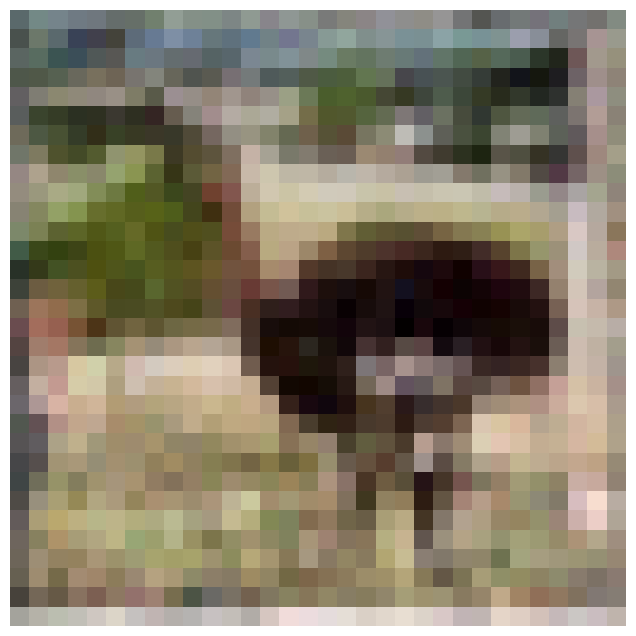

In [6]:
 #@title ODE sampling
batch_size = 1
shape = (batch_size, 3, 32, 32)
sampling_fn = sampling.get_ode_sampler(sde,                                        
                                       shape, 
                                       inverse_scaler,                                       
                                       denoise=True, 
                                       eps=sampling_eps,
                                       device=config.device)
x, nfe, accs = sampling_fn(score_model)
show_samples(x)

In [ ]:
plt.plot(np.linspace(0,1,19), [acc.cpu() for acc in accs])

tensor(2.2746, device='cuda:0')
tensor(2.0868, device='cuda:0')
tensor(2.4288, device='cuda:0')
tensor(3.6386, device='cuda:0')
tensor(8.5817, device='cuda:0')
tensor(21.6379, device='cuda:0')
tensor(51.1541, device='cuda:0')
tensor(102.7412, device='cuda:0')
tensor(204.1913, device='cuda:0')
tensor(437.9593, device='cuda:0')
tensor(953.7001, device='cuda:0')
tensor(2112.3667, device='cuda:0')
tensor(4521.6646, device='cuda:0')
tensor(9285.7188, device='cuda:0')
tensor(18735.5898, device='cuda:0')
tensor(37662.3359, device='cuda:0')
tensor(78931.6094, device='cuda:0')
tensor(189018.8594, device='cuda:0')
tensor(645919.5625, device='cuda:0')


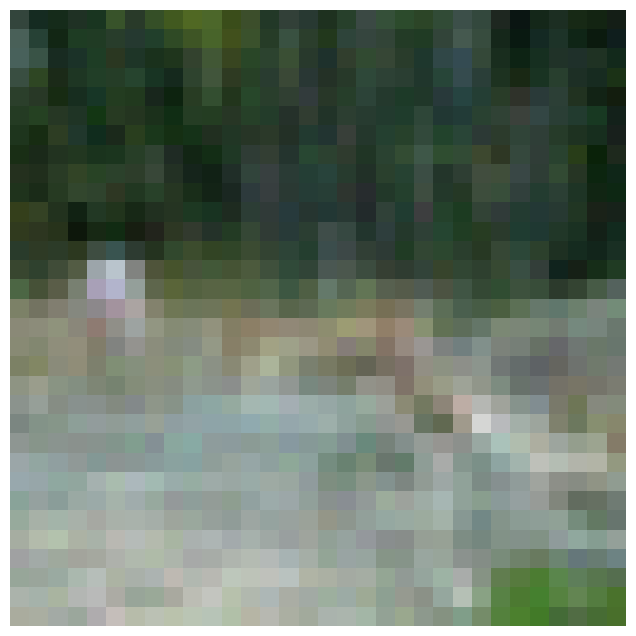

In [32]:
 #@title ODE sampling
batch_size = 1
shape = (batch_size, 3, 32, 32)
sampling_fn = sampling.get_ode_sampler(sde,                                        
                                       shape, 
                                       inverse_scaler,                                       
                                       denoise=True, 
                                       eps=sampling_eps,
                                       device=config.device)
x, nfe = sampling_fn(score_model)
show_samples(x)

In [ ]:
#@title Likelihood computation
train_ds, eval_ds, _ = datasets.get_dataset(config, uniform_dequantization=True, evaluation=True)
eval_iter = iter(eval_ds)
bpds = []
likelihood_fn = likelihood.get_likelihood_fn(sde,                                              
                                             inverse_scaler,                                             
                                             eps=1e-5)
for batch in eval_iter:
  img = batch['image']._numpy()
  img = torch.tensor(img).permute(0, 3, 1, 2).to(config.device)
  img = scaler(img)
  bpd, z, nfe = likelihood_fn(score_model, img)
  bpds.extend(bpd)
  print(f"average bpd: {torch.tensor(bpds).mean().item()}, NFE: {nfe}")

Text(0.5, 1.0, 'Reconstructed images')

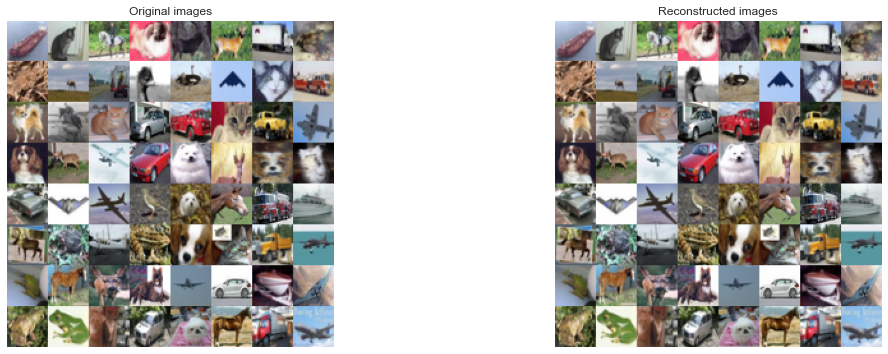

In [ ]:
#@title Representations
train_ds, eval_ds, _ = datasets.get_dataset(config, uniform_dequantization=False, evaluation=True)
eval_batch = next(iter(eval_ds))
eval_images = eval_batch['image']._numpy()
shape = (batch_size, 3, 32, 32)

likelihood_fn = likelihood.get_likelihood_fn(sde, inverse_scaler, eps=1e-5)
sampling_fn = sampling.get_ode_sampler(sde, shape, inverse_scaler,
                                       denoise=True, eps=sampling_eps, device=config.device)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(image_grid(eval_images))
plt.title('Original images')

eval_images = torch.from_numpy(eval_images).permute(0, 3, 1, 2).to(config.device)
_, latent_z, _ = likelihood_fn(score_model, scaler(eval_images))

x, nfe = sampling_fn(score_model, latent_z)

x = x.permute(0, 2, 3, 1).cpu().numpy()
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(image_grid(x))
plt.title('Reconstructed images')

# Controllable generation

Several demonstrations on how to solve inverse problems with our SDE framework.

Recommended settings

| dataset | SDE | predictor | corrector | snr | n_steps |
|:----:|:----:|:----------:|:--------:|:---:|:----:|
|CIFAR-10 | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.16| 1|
|CIFAR-10 | VP | EulerMaruyamaPredictor | None | - | - |
|CIFAR-10 | subVP| EulerMaruyamaPredictor | None | - | - |
| LSUN/CelebA-HQ/FFHQ 256px | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.075 | 1 |
| FFHQ 1024px | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.15| 1 |

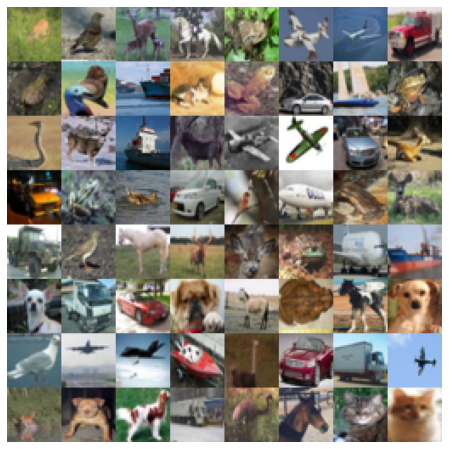

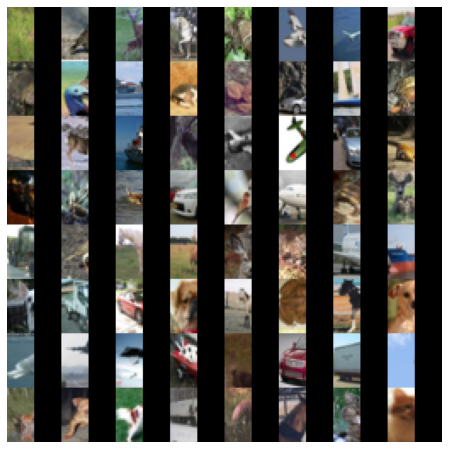

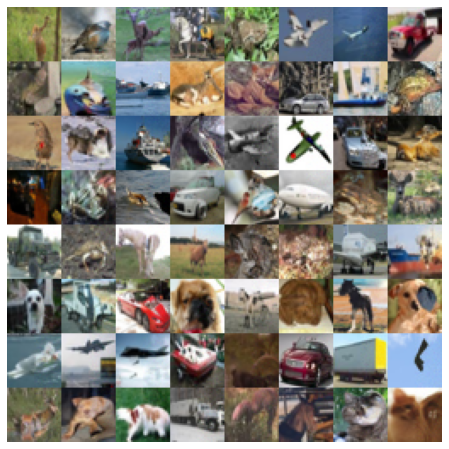

In [ ]:
#@title PC inpainting
train_ds, eval_ds, _ = datasets.get_dataset(config)
eval_iter = iter(eval_ds)
bpds = []

predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16 #@param {"type": "number"}
n_steps = 1 #@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}

pc_inpainter = controllable_generation.get_pc_inpainter(sde,
                                                        predictor, corrector,
                                                        inverse_scaler,
                                                        snr=snr,
                                                        n_steps=n_steps,
                                                        probability_flow=probability_flow,
                                                        continuous=config.training.continuous,
                                                        denoise=True)
batch = next(eval_iter)
img = batch['image']._numpy()
img = torch.from_numpy(img).permute(0, 3, 1, 2).to(config.device)
show_samples(img)

mask = torch.ones_like(img)
mask[:, :, :, 16:] = 0.
show_samples(img * mask)


x = pc_inpainter(score_model, scaler(img), mask)
show_samples(x)

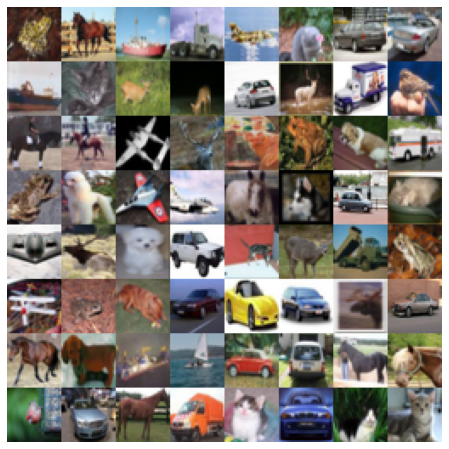

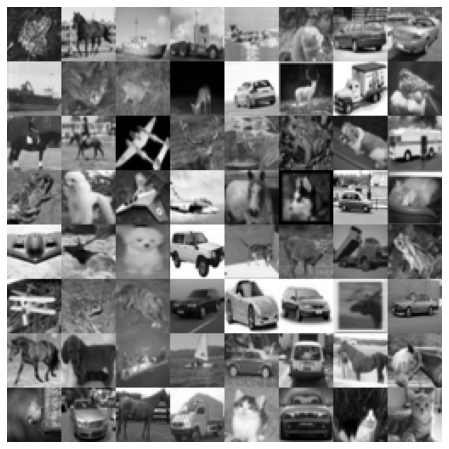

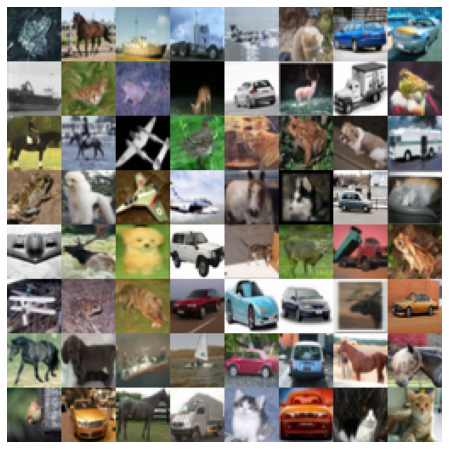

In [25]:
#@title PC colorizer
train_ds, eval_ds, _ = datasets.get_dataset(config)
eval_iter = iter(eval_ds)
bpds = []

predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16 #@param {"type": "number"}
n_steps = 1 #@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}

batch = next(eval_iter)
img = batch['image']._numpy()
img = torch.from_numpy(img).permute(0, 3, 1, 2).to(config.device)
show_samples(img)
gray_scale_img = torch.mean(img, dim=1, keepdims=True).repeat(1, 3, 1, 1)
show_samples(gray_scale_img)
gray_scale_img = scaler(gray_scale_img)
pc_colorizer = controllable_generation.get_pc_colorizer(
    sde, predictor, corrector, inverse_scaler,
    snr=snr, n_steps=n_steps, probability_flow=probability_flow,
    continuous=config.training.continuous, denoise=True
)
x = pc_colorizer(score_model, gray_scale_img)

show_samples(x)

## Class-conditional generation



Check out the [class-conditional generation section](https://colab.research.google.com/drive/1dRR_0gNRmfLtPavX2APzUggBuXyjWW55#scrollTo=HiYRNB-Wk329&line=3&uniqifier=1) in our [JAX demo](https://colab.research.google.com/drive/1dRR_0gNRmfLtPavX2APzUggBuXyjWW55?usp=sharing)